## Wavelet data generation..

In [6]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import cv2
import os
import numpy as np
import random
import seaborn as sn
import pandas as pd

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls "/content/drive/My Drive/Colab Notebooks/ml cnn project"

accuracy_and_loss_1.png        model1.sav
accuracy_and_loss_2.png        model2.pkl
checkpoint		       model.cpkt.data-00000-of-00001
CNN.ipynb		       model.cpkt.index
confusion_mrtx_test_load.png   model.pkl
confusion_mrtx_test.png        model_using_saving
confusion_mrtx_train_load.png  spectrogram


In [9]:
path = ""
#path = "/content/drive/My Drive/Colab Notebooks/ml cnn project/"

In [10]:
def wavelet_generator(genre_name, shuffle_samples = False):
  img_names = os.listdir('genres/'+genre_name)
  os.makedirs('wavelets/train/'+genre_name)
  os.makedirs('wavelets/test/'+genre_name)
  print(genre_name)
  if shuffle_samples == True:
    random.shuffle(img_names)
  train_names = img_names[:60]
  test_names = img_names[60:]
  song_number = 0
  for song in train_names:
    song_number+=1
    x , sr = librosa.load('genres/'+genre_name+'/'+song)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x)
    plt.savefig('wavelets/train/'+genre_name+'/'+str(song_number)+'.png')
    plt.close()
  
  song_number = 0
  for song in test_names:
    song_number+=1
    x , sr = librosa.load('genres/'+genre_name+'/'+song)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveshow(x)
    plt.savefig('wavelets/test/'+genre_name+'/'+str(song_number)+'.png')
    plt.close()

In [ ]:
classes = [a for a in os.listdir('genres') if '.' not in a]
print(classes)

In [ ]:
#Actual wavelet generation
for genre in classes:
    wavelet_generator(genre)

## Spectrogram generation..

In [11]:
def spectogram_generator(genre_name, shuffle_samples = False):
  img_names = os.listdir('genres/'+genre_name)
  os.makedirs('spectrogram/train/'+genre_name)
  os.makedirs('spectrogram/test/'+genre_name)
  print(genre_name)
  if shuffle_samples == True:
    random.shuffle(img_names)
  train_names = img_names[:60]
  test_names = img_names[60:]
  song_number = 0
  for song in train_names:
    song_number+=1
    x , sr = librosa.load('genres/'+genre_name+'/'+song)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/train/'+genre_name+'/'+str(song_number)+'.png')
    plt.close()
  
  song_number = 0
  for song in test_names:
    song_number+=1
    x , sr = librosa.load('genres/'+genre_name+'/'+song)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/test/'+genre_name+'/'+str(song_number)+'.png')
    plt.close()

In [ ]:
classes = [a for a in os.listdir('genres') if '.' not in a]
print(classes)

In [ ]:
#Actual spectogram generation
for genre in classes:
    spectogram_generator(genre)

## Model training..

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os
import numpy as np

In [13]:
labels = ['blues', 'classical', 'country', 'disco', 'Electric-Genre', 'hiphop', 'jazz', 'k-pop', 'metal', 'pop', 'reggae', 'rock']
img_size = 256
def get_data(data_dir, number_samples):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        count = 1
        for img in os.listdir(path):
            if count<=number_samples:
                try:
                    img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                    data.append([resized_arr, class_num])
                except Exception as e:
                    print(e)
                count = count + 1
            else:
                break
    return np.array(data, dtype="object")

In [14]:
train = get_data(path+'spectrogram/train', 100)
val = get_data(path+'spectrogram/test', 100)

In [ ]:
import pickle
pickle.dump(train,open(path+'train.pkl', "wb"))
pickle.dump(val,open(path+'val.pkl', "wb"))

In [15]:
#Displaying
print("Image shape", train[0][0].shape)
image = train[0][0]
#print(train)
print(train.shape)
print(val.shape)
#cv2.imshow('image window',image)
#cv2.waitKey(0); cv2.destroyAllWindows(); cv2.waitKey(1)

Image shape (256, 256, 3)
(720, 2)
(480, 2)


In [16]:
x_train = []
y_train = []
x_val = []
y_val = []
mean_train = []
sd_train = []
mean_val = []
sd_val = []


for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    mean_train.append(np.mean(feature))
    sd_train.append(np.std(feature))
    
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    mean_val.append(np.mean(feature))
    sd_val.append(np.std(feature))

x_train = np.array(x_train).astype('float64')
x_val = np.array(x_val).astype('float64') 
mean_train = np.array(mean_train)
sd_train = np.array(sd_train)
mean_val = np.array(mean_val)
sd_val = np.array(sd_val)

for i in range(len(x_train)):
    x_train[i] = np.divide(np.subtract(x_train[i], mean_train[i]), sd_train[i])

for i in range(len(x_val)):
    x_val[i] = np.divide(np.subtract(x_val[i], mean_val[i]), sd_val[i])

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
import pickle
pickle.dump(x_train,open(path+'x_train.pkl', "wb"))
pickle.dump(x_val,open(path+'x_val.pkl', "wb"))
pickle.dump(y_train,open(path+'y_train.pkl', "wb"))
pickle.dump(y_val,open(path+'y_val.pkl', "wb"))

In [ ]:
print(x_train)
print(x_val)
print(y_train)
print(y_val)

In [38]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [40]:
model = Sequential()

model.add(Conv2D(32,(3, 3), activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D(pool_size=(3, 3), strides= (2,2), padding="same"))
BatchNormalization()

model.add(Conv2D(32,(3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(3, 3), strides= (2,2), padding="same"))
BatchNormalization()

model.add(Conv2D(32,(2, 2), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides= (2,2), padding="same"))
BatchNormalization()

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(12, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        4128      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 31, 32)      

In [41]:
opt = Adam(learning_rate = 0.001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

In [42]:
epoch = 52
history = model.fit(x_train,y_train,epochs = epoch, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/52
23/23 [==============================] - 3s 92ms/step - loss: 2.7526 - accuracy: 0.1319 - val_loss: 2.3545 - val_accuracy: 0.2313
Epoch 2/52
23/23 [==============================] - 2s 72ms/step - loss: 2.1726 - accuracy: 0.2403 - val_loss: 2.1728 - val_accuracy: 0.3083
Epoch 3/52
23/23 [==============================] - 2s 81ms/step - loss: 2.0165 - accuracy: 0.3139 - val_loss: 2.0704 - val_accuracy: 0.3167
Epoch 4/52
23/23 [==============================] - 2s 81ms/step - loss: 1.8376 - accuracy: 0.3444 - val_loss: 1.9092 - val_accuracy: 0.3354
Epoch 5/52
23/23 [==============================] - 2s 82ms/step - loss: 1.6849 - accuracy: 0.4028 - val_loss: 1.8988 - val_accuracy: 0.3604
Epoch 6/52
23/23 [==============================] - 2s 81ms/step - loss: 1.6110 - accuracy: 0.4139 - val_loss: 1.7664 - val_accuracy: 0.3958
Epoch 7/52
23/23 [==============================] - 2s 69ms/step - loss: 1.5177 - accuracy: 0.4306 - val_loss: 1.6899 - val_accuracy: 0.4250
Epoch 8/52
23

In [43]:
import pickle
model.save_weights(path+'model.cpkt')
pickle.dump(history.history, open(path+'model.pkl','wb'))

In [44]:
model1 = pickle.load(open(path+'model.pkl', 'rb'))

In [45]:
import pickle
fileName1="model1.sav"
fileName2="model2.pkl"
pickle.dump(model,open(path+fileName1, "wb"))
pickle.dump(model,open(path+fileName2, "wb"))

INFO:tensorflow:Assets written to: ram://9b494490-b03b-406e-8348-1bd23c5ef750/assets
INFO:tensorflow:Assets written to: ram://adbc2940-d4db-4cc1-bdb7-9fd9f42c8891/assets


In [46]:
model2 = pickle.load(open(path+"model1.sav", 'rb'))
model3 = pickle.load(open(path+"model2.pkl", 'rb'))

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
model.save(path+'model_using_saving')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/ml cnn project/model_using_saving/assets


In [48]:
from tensorflow import keras
model_using_saving = keras.models.load_model(path+'model_using_saving')

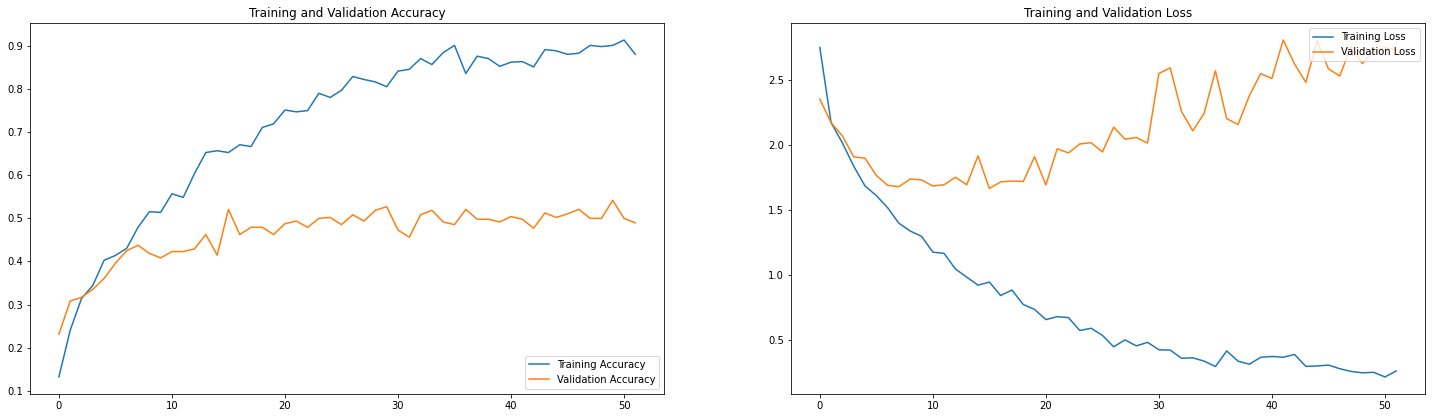

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(path+'accuracy_and_loss_1.png',bbox_inches = 'tight')
plt.show()

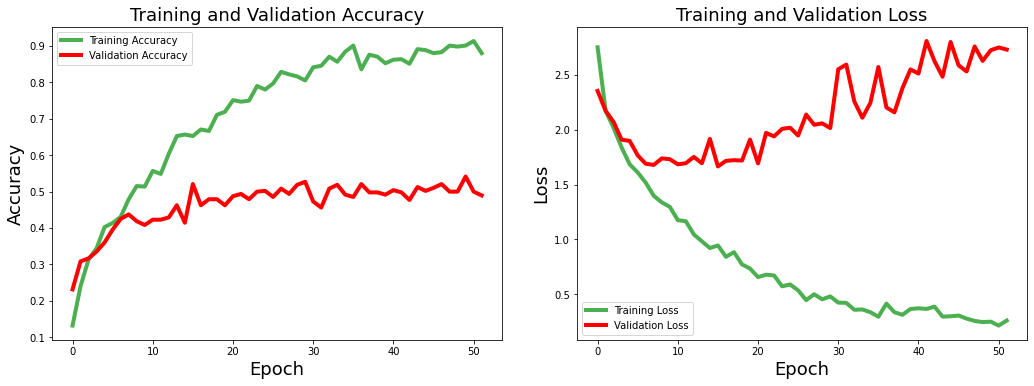

<Figure size 432x288 with 0 Axes>

In [50]:
import pickle
history = pickle.load(open(path+'model.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epoch)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
plt.savefig(path+'accuracy_and_loss_2.png',bbox_inches = 'tight')
plt.show()
plt.clf()

In [51]:
predictions = np.argmax(model.predict(x_val), axis=-1)
print(classification_report(y_val, predictions, target_names = labels))

                precision    recall  f1-score   support

         blues       0.26      0.30      0.28        40
     classical       0.77      0.85      0.81        40
       country       0.25      0.33      0.29        40
         disco       0.38      0.38      0.38        40
Electric-Genre       0.80      0.70      0.75        40
        hiphop       0.47      0.23      0.31        40
          jazz       0.29      0.31      0.30        39
         k-pop       0.77      0.90      0.83        41
         metal       0.66      0.62      0.64        40
           pop       0.80      0.60      0.69        40
        reggae       0.29      0.50      0.36        40
          rock       0.32      0.15      0.20        40

      accuracy                           0.49       480
     macro avg       0.51      0.49      0.49       480
  weighted avg       0.51      0.49      0.49       480



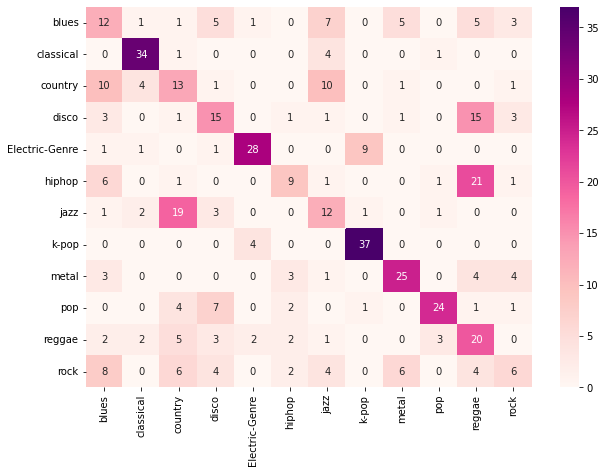

In [52]:
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig(path+'confusion_mrtx_test.png',bbox_inches = 'tight')

In [53]:
model_load = Sequential()

model_load.add(Conv2D(32,(3, 3), activation="relu", input_shape=(256,256,3), kernel_initializer='random_normal', bias_initializer='zeros'))
model_load.add(MaxPool2D(pool_size=(3, 3), strides= (2,2), padding="same"))
BatchNormalization()

model_load.add(Conv2D(32,(3, 3), activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
model_load.add(MaxPool2D(pool_size=(3, 3), strides= (2,2), padding="same"))
BatchNormalization()

model_load.add(Conv2D(32,(2, 2), activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'))
model_load.add(MaxPool2D(pool_size=(2, 2), strides= (2,2), padding="same"))
BatchNormalization()

model_load.add(Flatten())
model_load.add(Dense(64, activation='relu', kernel_initializer='random_normal', bias_initializer='zeros'))
model_load.add(Dropout(0.3))
model_load.add(Dense(12, activation='softmax', kernel_initializer='random_normal', bias_initializer='zeros'))

model_load.summary()
opt = Adam(learning_rate = 0.001)
model_load.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])
model_load.load_weights(path+'model.cpkt')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 62, 62, 32)        4128      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 32)      

In [54]:
model_load.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 62, 62, 32)        4128      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 31, 31, 32)      

In [55]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        4128      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 31, 32)      

In [56]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        4128      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 31, 32)      

In [57]:
model_using_saving.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        4128      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 31, 32)      

15/15 [==============================] - 1s 29ms/step - loss: 2.7321 - accuracy: 0.4896
Restored model, test accuracy: 48.96%
Restored model, test loss:  2.73%
                precision    recall  f1-score   support

         blues       0.26      0.30      0.28        40
     classical       0.77      0.85      0.81        40
       country       0.25      0.33      0.29        40
         disco       0.38      0.38      0.38        40
Electric-Genre       0.80      0.70      0.75        40
        hiphop       0.47      0.23      0.31        40
          jazz       0.29      0.31      0.30        39
         k-pop       0.77      0.90      0.83        41
         metal       0.66      0.62      0.64        40
           pop       0.80      0.60      0.69        40
        reggae       0.29      0.50      0.36        40
          rock       0.32      0.15      0.20        40

      accuracy                           0.49       480
     macro avg       0.51      0.49      0.49       48

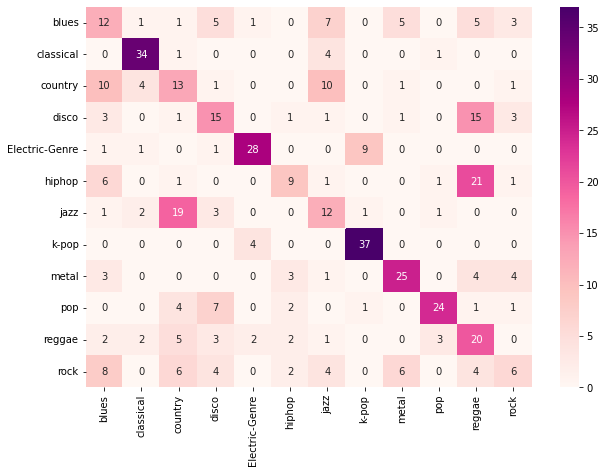

In [58]:
# Evaluate the restored model
loss, acc = model_load.evaluate(x_val, y_val, verbose=1)
print('Restored model, test accuracy: {:5.2f}%'.format(100 * acc))
print('Restored model, test loss: {:5.2f}%'.format(loss))
predictions = np.argmax(model_load.predict(x_val), axis=-1)
print(classification_report(y_val, predictions, target_names = labels))

cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
#plt.savefig(path+'confusion_mrtx_test_load.png',bbox_inches = 'tight')

23/23 [==============================] - 1s 31ms/step - loss: 0.0495 - accuracy: 0.9903
Restored model, train accuracy: 99.03%
Restored model, train loss:  0.05%
                precision    recall  f1-score   support

         blues       0.98      1.00      0.99        60
     classical       0.98      1.00      0.99        60
       country       0.97      1.00      0.98        60
         disco       1.00      1.00      1.00        60
Electric-Genre       1.00      0.97      0.98        60
        hiphop       1.00      0.98      0.99        60
          jazz       1.00      0.95      0.97        60
         k-pop       0.97      1.00      0.98        60
         metal       0.98      1.00      0.99        60
           pop       1.00      1.00      1.00        60
        reggae       1.00      1.00      1.00        60
          rock       1.00      0.98      0.99        60

      accuracy                           0.99       720
     macro avg       0.99      0.99      0.99       

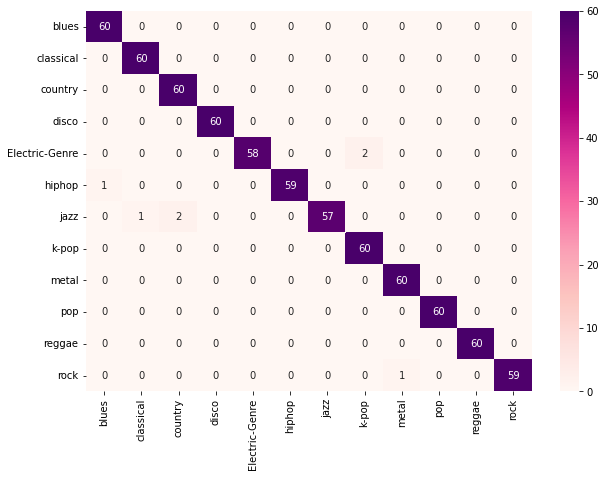

In [59]:
loss1, acc1 = model_load.evaluate(x_train, y_train, verbose=1)
print('Restored model, train accuracy: {:5.2f}%'.format(100 * acc1))
print('Restored model, train loss: {:5.2f}%'.format(loss1))
predictions = np.argmax(model_load.predict(x_train), axis=-1)
print(classification_report(y_train, predictions, target_names = labels))

cm1 = confusion_matrix(y_train, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
#plt.savefig(path+'confusion_mrtx_train_load.png',bbox_inches = 'tight')